# TDA Introduction

This notebook will serve as an introduction to concepts and techniques in topological data analysis. Hopefully this can be achieved through a mix of some high level on the theory parts and practical code examples with some toy datasets.
For the code parts we'll use __[keppler mapper](https://github.com/MLWave/kepler-mapper)__ for the mapper applications with some graphviz for showing simple example plots.
On the theory side we'll pull from a few places. First stop will be Hatchers __[point set topology notes](https://www.math.cornell.edu/~hatcher/Top/TopNotes.pdf)__ but we'll also use Robert Ghrists *Elementary Applied Topology*


## Some Topology

From a pure maths point of view topology is a study of open sets. The more inuitive line of thinking is that it's a sort of squishy geometry - it's concerned with the shape of spaces but you're allowed to stretch and pull and bend while still considering the results to be essentially the same.

Topology looks at shape through the language of open sets. In fact a *topology* on a set $X$ is a collection $O$ of open sets of $X$ satisfying closure under unions and intersections and with both $\emptyset$ and $X$ contained in $O$.

Continuous maps between topological spaces map open sets to open sets. If a space $X$ can be continuously deformed into a space $Y$ then they're *homeomorphic* and equivalent from a topological point of view.
The typical example used here is that of a mug being the same as a donut (torus).

### Point Clouds and cell complexes

TODO

### Mapper algorithm in python

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors, cm
import kmapper as km
import graphviz as gz
import itertools
import colorsys

np.random.seed(1234)

%matplotlib inline

As a toy example lets randomly sample a handful of points from a sphere and use these as the input to mapper to get a feel for how the algorithm works

In [2]:
# Function to randomly pick from an n-sphere

def sample_spherical(npoints, ndim=3):
    vec = np.random.randn(ndim, npoints)
    vec /= np.linalg.norm(vec, axis=0)
    return vec

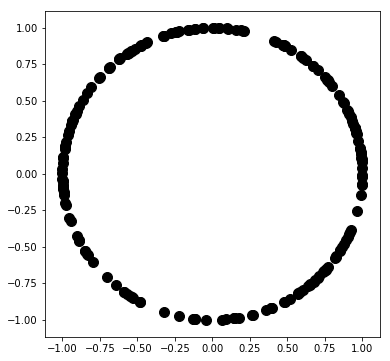

In [3]:
xi, yi = sample_spherical(200, 2)

points=zip(xi, yi)
X=np.array(points)

fig, ax = plt.subplots(1, 1)
fig.set_size_inches(6,6)
ax.scatter(xi, yi, s=100, c='k', zorder=10)

Lets use kmapper to perform the first step of the mapper algorithm on this dataset - appllying a filter function or lens to the data to map it to real numbers. To make a simple illustration this lens will simply be a projection onto the x-axis

(array([42., 11., 20., 10., 11., 14.,  8., 18., 24., 42.]),
 array([-9.99976485e-01, -7.99985606e-01, -5.99994727e-01, -4.00003848e-01,
        -2.00012969e-01, -2.20896275e-05,  1.99968789e-01,  3.99959668e-01,
         5.99950547e-01,  7.99941426e-01,  9.99932305e-01]),
 <a list of 10 Patch objects>)

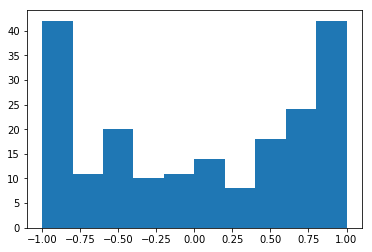

In [4]:
mapper = km.KeplerMapper(verbose=0)
lens = mapper.fit_transform(X, projection=[0], scaler=None)

plt.hist(lens)

The histogram above is to help show what will happen in the next stage. The output is bucketed and the preimage of each bucket forms the basis for the cell complex construction.

This is performed by the map function - we'll split the output into 10 cubes but with an overlap of 80% to ensure we'll get enough links.

In [5]:
graph = mapper.map(lens, X, nr_cubes=10, overlap_perc=0.8)

In [6]:
graph['nodes'].keys()

['cube2_cluster0',
 'cube2_cluster1',
 'cube7_cluster1',
 'cube5_cluster1',
 'cube5_cluster0',
 'cube0_cluster0',
 'cube7_cluster0',
 'cube4_cluster0',
 'cube4_cluster1',
 'cube8_cluster0',
 'cube8_cluster1',
 'cube1_cluster1',
 'cube1_cluster0',
 'cube3_cluster1',
 'cube3_cluster0',
 'cube6_cluster0',
 'cube6_cluster1',
 'cube9_cluster0']

The list of clusters above are the 0 simplices for the cell complex that has been built onto the input dataset by the mapper algorithm. Lets take a closer look at some of these clusters to see what points have been added to them.

The naming convention is useful and gives an indication of what we might expect. Remember the lens was simply projecting onto the x axis so the range is -1 to 1. This interval has been broken into 10 even cubes (albeit with an 80% overlap). So cubes 0 and 9 would be the left and rightmost ones respectively. Notice that these are the only 2 which only have a single cluster associated. For the rest we have 2, which corresponds to the fact that if you take a slice at a particular x value there'll be 2 points on the circle returned

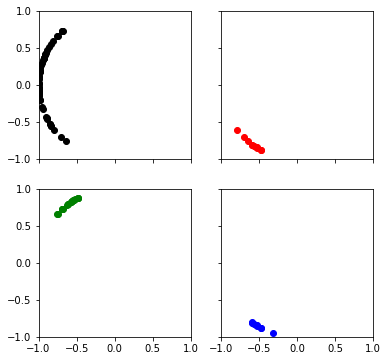

In [7]:
# Subset on the points within a selection of clusters
c0_0=[X[i] for i in graph['nodes']['cube0_cluster0']]
c1_0=[X[i] for i in graph['nodes']['cube1_cluster0']]
c1_1=[X[i] for i in graph['nodes']['cube1_cluster1']]
c2_0=[X[i] for i in graph['nodes']['cube2_cluster0']]

# Plot each of these groups
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True)
fig.set_size_inches(6,6)
for (m,n),sub in np.ndenumerate(axes):
    sub.set_ylim((-1,1))
    sub.set_xlim((-1,1))
axes[0, 0].scatter([x[0] for x in c0_0], [x[1] for x in c0_0], c='k')
axes[0, 1].scatter([x[0] for x in c1_0], [x[1] for x in c1_0], c='r')
axes[1, 0].scatter([x[0] for x in c1_1], [x[1] for x in c1_1], c='g')
axes[1, 1].scatter([x[0] for x in c2_0], [x[1] for x in c2_0], c='b')

Finally we plot the nerve that is produced using graphviz to show that the original shape is returned

Kepler Mapper has it's own plotting tools to produce html output with d3. The map function that we called above also gives back the nodes and edges of the graph in a dictionary, which is pretty nice because we can then pass them into other plotting tools. We're using graphviz so that we can embed the output within the notebook

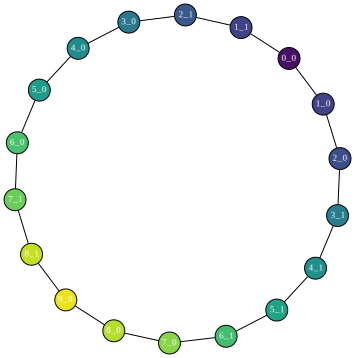

In [8]:
network=gz.Graph()
network.attr(layout='neato')
network.attr('edge', len='0.7')
network.attr('node', shape='circle', fixedsize='true', width='0.3', \
             label=None, fontsize='9', style='filled', fontcolor='white')

for node in graph['links']:
    for nbr in graph['links'][node]:
        # We'll remove the 'cube' and 'cluster' strings from the label to avoid clutter
        node=str.replace(str.replace(node,'cube',''),'cluster','')
        nbr=str.replace(str.replace(nbr,'cube',''),'cluster','')
        network.edge(node, nbr)
        
# Colour the nodes based on the average x value of points in the cluster
norm = colors.Normalize(vmin = -1, vmax = 1)
clrmap=cm.ScalarMappable(norm = norm, cmap = cm.viridis)

for node in graph['nodes']:
    avg_x=np.average([X[i][0] for i in graph['nodes'][node]])
    color=clrmap.to_rgba(avg_x)
    color=colorsys.rgb_to_hsv(color[0], color[1], color[2])
    node=str.replace(str.replace(node,'cube',''),'cluster','')
    network.node(node, fillcolor="%f, %f, %f" % (color[0], color[1], color[2]))
    
# Display the graph
network

So we can see that mapper has returned a cicle for us and that points in cluster 0_0 have the lowest x values while cluster 9_0 has the highest.

For reference and comparison, here's what the keppler mapper output looks like

In [9]:
%%capture
mapper.visualize(graph, path_html="circle_example_1.html",
                 title="Basic circle")

<img src='https://raw.githubusercontent.com/noelano/TDA/master/kmapper_circles_output.PNG' width='70%'>